In [1]:
import os
import sys
import json
import copy
import numpy as np
from IPython.display import Image as IImage

import hydra
from hydra.core.global_hydra import GlobalHydra

import torch
from PIL import Image
from omegaconf import OmegaConf

from scenarionet.common_utils import read_scenario, read_dataset_summary

from metadrive.policy.replay_policy import ReplayEgoCarPolicy
from metadrive.envs.scenario_env import ScenarioOnlineEnv
from metadrive.scenario.scenario_description import ScenarioDescription

from unitraj.datasets.base_dataset import BaseDataset

sys.path.append('../') # for import of local dataset and model modules

from datasets.basic_dataset import BasicDataset

In [2]:
#@title constants; change as needed
OUTPUT_DIR = "output"  # where visualizations are saved relative to this file
CKPT = None
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CUR_TIME_IDX = 20  # don't modify this

TRAVERSE_PATH = "/fs/nexus-projects/pc_driving/datasets/traverse"

TRAIN_DATA_PATH = f"{TRAVERSE_PATH}/sd_sumo/train"
VAL_DATA_PATH = f"{TRAVERSE_PATH}/sd_sumo/val"
CACHE_PATH = f"{TRAVERSE_PATH}/sd_sumo/cache"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
# helper function to create a gif file from a list of images
def make_GIF(frames, name="demo.gif"):
    print(f"Generate gif @ {name}...")
    imgs = [frame for frame in frames]
    imgs = [Image.fromarray(img) for img in imgs]
    imgs[0].save(name, save_all=True, append_images=imgs[1:], duration=50, loop=0)

# creates an environment compatible with the datasets and model predictions
def create_env(data_path, threeD_render=False):
    return ScenarioOnlineEnv(
        {
            "manual_control": False,
            "reactive_traffic": False,
            "use_render": threeD_render,
            "agent_policy": ReplayEgoCarPolicy,
            "data_directory": data_path,  # use nuscenes data
            "num_scenarios": 10,  # load 10 scenarios
        }
    )

# reads scenarionet data
def get_scenario_list(data_path):
    scenario_list = []
    _, summary_list, mapping = read_dataset_summary(data_path)
    data_list = list(summary_list)
    # data_path, mapping, list(summary_list), dataset_name

    for cnt, file_name in enumerate(data_list):
        scenario = read_scenario(data_path, mapping, file_name)
        scenario_list.append(scenario)

    return scenario_list

# helper function for sending dictionary samples to devices
def send_data_to_device(data, device):
    if isinstance(data, dict):
        for key in data.keys():
            data[key] = send_data_to_device(data[key], device)
    elif isinstance(data, list):
        for i in range(len(data)):
            data[i] = send_data_to_device(data[i], device)
    elif isinstance(data, torch.Tensor):
        data = data.to(device)

    return data

# replaces the GT trajectory after CUR_TIME_IDX to the predicted trajectory
def modify_scenario_with_prediction(scenario, processed_scenario, prediction):
    scenario = copy.deepcopy(scenario)
    # sdc_id = scenario[ScenarioDescription.METADATA][ScenarioDescription.SDC_ID]
    sdc_id = 'ego'
    ego_idx = processed_scenario["input_dict"]["center_objects_id"].index(sdc_id)
    # ego_idx = 0
    ego_prediction = prediction[ego_idx]
    timesteps = ego_prediction.shape[0]

    scenario[ScenarioDescription.TRACKS][sdc_id]["state"]["position"][-timesteps:, 0:2] = ego_prediction[:, 0:2]
    scenario[ScenarioDescription.TRACKS][sdc_id]["state"]["heading"][-timesteps:, 0] = ego_prediction[:, 2] # + start_heading
    return scenario

In [4]:
# main render function definition; 
def render(data_path: str, dataset: BaseDataset, model: torch.nn.Module = None, idxs: int = 0, threeD_render=False):
    # threeD_render=False # turn on this to enable 3D render. It only works when you have a screen and not running on Colab.
    os.environ["SDL_VIDEODRIVER"] = "dummy"  # Hide the pygame window

    env = create_env(data_path, threeD_render=threeD_render)
    scenario_list = get_scenario_list(data_path)
    output_files = []
    
    try:
        for i in idxs:
            scenario_to_render_gt = scenario_list[i]
            processed_scenario = dataset.preprocess(scenario_to_render_gt)
            processed_scenario = dataset.process(processed_scenario)
            processed_scenario = dataset.postprocess(processed_scenario)
            processed_scenario = dataset.collate_fn(processed_scenario)
    
            env.set_scenario(scenario_data=scenario_to_render_gt)
            print("\nSimulate Scenario (GT): {}".format(i))
            o, _ = env.reset()
            # env.agent_manager.agent_policy.set_prediction(action)
            # ego_idx = processed_scenario['input_dict']['center_objects_id'].index(env.engine.traffic_manager.sdc_object_id)
            frames = []
            for _ in range(1, 100000):
                o, r, tm, tc, info = env.step([0.0, 0.0])
                frames.append(env.render(mode="top_down", film_size=(4000, 4000), screen_size=(500, 500)))
                if tm or tc:
                    make_GIF(frames, name=f"{OUTPUT_DIR}/scenario_{scenario_to_render_gt['id']}_{i}_gt.gif")
                    output_files.append(f"{OUTPUT_DIR}/scenario_{scenario_to_render_gt['id']}_{i}_gt.gif")
                    break
    
            if model is not None:
                # model prediction here
                with torch.no_grad():
                    processed_scenario = send_data_to_device(processed_scenario, DEVICE)
                    prediction, loss_dict = model(processed_scenario)
        
                pred_trajs = prediction["predicted_trajectory"]
                num_center_objs, k, num_steps, _ = pred_trajs.shape
                pred_trajs_mean, pred_vel = pred_trajs[:, :, :, 0:2], pred_trajs[:, :, :, 5:7]
                highest_prob_k = prediction["predicted_probability"].argmax(dim=-1)
                highest_prob_pos = pred_trajs_mean[torch.arange(num_center_objs), highest_prob_k]
                highest_prob_pos = highest_prob_pos[..., [1, 0]] # TODO: delete
                # highest_prob_vel = pred_vel[torch.arange(num_center_objs), highest_prob_k]
                starting_pos = torch.Tensor(scenario_to_render_gt[ScenarioDescription.TRACKS]['ego']['state']['position'][CUR_TIME_IDX, 0:2]).to(DEVICE)
                zeros_pos = torch.zeros(highest_prob_pos.shape[0], 1, highest_prob_pos.shape[-1]).to(DEVICE)
                highest_prob_pos_prepended = torch.cat([zeros_pos, highest_prob_pos], dim=1) + starting_pos
                highest_prob_vel = torch.diff(highest_prob_pos_prepended, dim=1)
                highest_prob_heading = torch.atan2(highest_prob_vel[..., 1], highest_prob_vel[..., 0])
                action = torch.cat([highest_prob_pos + starting_pos, highest_prob_heading.unsqueeze(-1)], dim=-1).cpu().numpy()
        
                scenario_to_render = modify_scenario_with_prediction(scenario_to_render_gt, processed_scenario, action)
        
                env.set_scenario(scenario_data=scenario_to_render)
                print("\nSimulate Scenario (Pred): {}".format(i))
                o, _ = env.reset()
                frames = []
                for step in range(1, 100000):
                    o, r, tm, tc, info = env.step([0.0, 0.0])
                    frames.append(env.render(mode="top_down", film_size=(4000, 4000), screen_size=(500, 500)))
                    if tm or tc:
                        print(f"Done at {step} total frames")
                        make_GIF(frames, name=f"{OUTPUT_DIR}/scenario_{scenario_to_render['id']}_{i}_pred.gif")
                        output_files.append(f"{OUTPUT_DIR}/scenario_{scenario_to_render['id']}_{i}_pred.gif")
                        break
    except Exception as e:
        print(f"Exception: {e}")
        raise e
        pass
        
    env.close()
    return output_files

In [5]:
config_path = "./"
config_name = "config_demo.yaml"

GlobalHydra.instance().clear()
hydra.initialize(version_base=None, config_path=config_path)
cfg = hydra.compose(config_name=config_name)

cfg["train_data_path"] = [TRAIN_DATA_PATH]
cfg["val_data_path"] = [VAL_DATA_PATH]
cfg["cache_path"] = CACHE_PATH

# check if cache has already been created
if os.path.exists(cfg["cache_path"]) and not os.path.isfile(cfg["cache_path"]) and os.listdir(cfg["cache_path"]):
    cfg["use_cache"] = True 
    cfg["overwrite_cache"] = False
    
print(cfg)

model = None
ckpt = None
val_set = BasicDataset(cfg, is_validation=True)
data_dir = val_set.data_path[0]
output_files = render(data_dir, val_set, model, idxs=[0, 1, 2, 3])

[INFO] Environment: ScenarioOnlineEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3


{'exp_name': 'test', 'ckpt_path': None, 'seed': 42, 'debug': True, 'devices': [0], 'load_num_workers': 0, 'train_data_path': ['/fs/nexus-projects/pc_driving/datasets/traverse/sd_sumo/train'], 'val_data_path': ['/fs/nexus-projects/pc_driving/datasets/traverse/sd_sumo/val'], 'cache_path': '/fs/nexus-projects/pc_driving/datasets/traverse/sd_sumo/cache', 'max_data_num': [None], 'starting_frame': [0], 'past_len': 21, 'future_len': 60, 'object_type': ['VEHICLE'], 'line_type': ['lane', 'stop_sign', 'road_edge', 'road_line', 'crosswalk', 'speed_bump'], 'masked_attributes': ['z_axis', 'size'], 'trajectory_sample_interval': 1, 'only_train_on_ego': False, 'center_offset_of_map': [30.0, 0.0], 'use_cache': True, 'overwrite_cache': False, 'store_data_in_memory': False, 'oversampling': False, 'undersampling': False, 'portion': None, 'nuscenes_dataroot': '/mnt/nas3_rcp_enac_u0900_vita_scratch/datasets/Prediction-Dataset/nuscenes/nuscenes_root', 'eval_nuscenes': False, 'eval_waymo': False, 'eval_argove

[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 10



Simulate Scenario (GT): 0


[INFO] Episode ended! Scenario Index: 6 Scenario id: 10_FCD_T001 Reason: arrive_dest.


Generate gif @ output/scenario_10_FCD_T001_1_0_gt.gif...

Simulate Scenario (GT): 1


/fs/nexus-scratch/lyzheng/miniconda3/envs/pc_driving/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/fs/nexus-scratch/lyzheng/miniconda3/envs/pc_driving/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/fs/nexus-scratch/lyzheng/miniconda3/envs/pc_driving/lib/python3.9/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
[INFO] Episode ended! Scenario Index: 1 Scenario id: 10_FCD_T001 Reason: arrive_dest.


Generate gif @ output/scenario_10_FCD_T001_10_1_gt.gif...

Simulate Scenario (GT): 2


[INFO] Episode ended! Scenario Index: 3 Scenario id: 10_FCD_T001 Reason: arrive_dest.


Generate gif @ output/scenario_10_FCD_T001_11_2_gt.gif...

Simulate Scenario (GT): 3


[INFO] Episode ended! Scenario Index: 1 Scenario id: 10_FCD_T001 Reason: arrive_dest.


Generate gif @ output/scenario_10_FCD_T001_2_3_gt.gif...


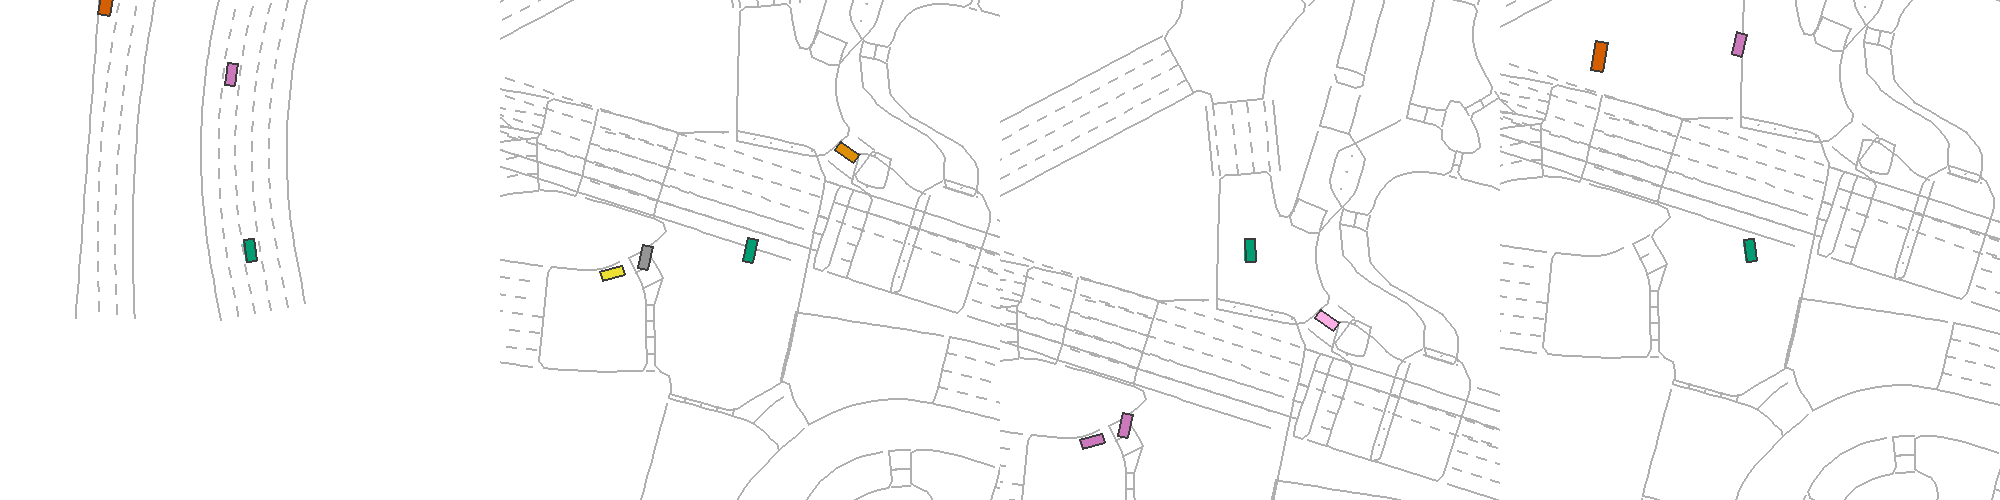

In [6]:
import imageio
import numpy as np    

#Create reader object for the gif
gifs = [imageio.get_reader(x) for x in output_files]

#If they don't have the same number of frame take the shorter
number_of_frames = min([gif.get_length() for gif in gifs])-1

#Create writer object
new_gif = imageio.get_writer('all_output.gif')

for frame_number in range(number_of_frames):
    imgs = [gif.get_next_data() for gif in gifs]
    # here is the magic
    new_image = np.hstack(imgs)
    new_gif.append_data(new_image)

[gif.close() for gif in gifs]  
new_gif.close()

# visulization
IImage(open("all_output.gif", 'rb').read())